# MNIST 手写数字识别
**自动计算准确度（metrics）**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, optimizers, datasets, Sequential, metrics

**加载数据**

In [2]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data()
print('datasets:', x_train.shape, y_train.shape, x_train.min(), x_train.max())
x_valid = x_train[:10000]
y_valid = y_train[:10000]
x_train = x_train[10000:]
y_train = y_train[10000:]

datasets: (60000, 28, 28) (60000,) 0 255


In [3]:
# reshpe and normalize
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255
x_valid = x_valid.reshape(-1, 28*28).astype('float32') / 255
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(50000, 784) (10000, 784) (10000, 784)
(50000,) (10000,) (10000,)


In [4]:
# 使用 from_tensor_slices 方法
db_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
db_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(64)
db_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

**定义模型**

In [5]:
model = Sequential([
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.build(input_shape=(None, 28*28))
model.summary()
model.compile(loss=keras.losses.CategoricalCrossentropy(),
             optimizer=keras.optimizers.SGD(),
             metrics=['accuracy'])
# optimizer = optimizers.SGD(lr=0.01)
# acc_meter = metrics.Accuracy()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


**自动训练模型**

In [6]:
y_train_onehot = tf.one_hot(y_train, depth=10)
y_valid_onehot = tf.one_hot(y_valid, depth=10)
print(y_train_onehot.shape, y_valid_onehot.shape)
print(y_train.shape, y_valid.shape)

(50000, 10) (10000, 10)
(50000,) (10000,)


In [7]:
# 此时 loss=keras.losses.CategoricalCrossentropy()
# 每个 目标值 y 需要经过 onehot 编码，变为一个向量
x_valid = tf.convert_to_tensor(x_valid)
x_train = tf.convert_to_tensor(x_train)

In [8]:

history = model.fit(x_train, y_train_onehot, validation_split=0.2, epochs=5)

# 当 loss=keras.losses.CategoricalCrossentropy() 时，目标值 y 不需要进行 onehot 编码
# history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 4s 104us/sample - loss: 0.8082 - accuracy: 0.7937 - val_loss: 0.3540 - val_accuracy: 0.9033
Epoch 2/5
40000/40000 [==============================] - 3s 80us/sample - loss: 0.3469 - accuracy: 0.9008 - val_loss: 0.2854 - val_accuracy: 0.9188
Epoch 3/5
40000/40000 [==============================] - 3s 81us/sample - loss: 0.2919 - accuracy: 0.9163 - val_loss: 0.2488 - val_accuracy: 0.9285
Epoch 4/5
40000/40000 [==============================] - 3s 81us/sample - loss: 0.2564 - accuracy: 0.9258 - val_loss: 0.2247 - val_accuracy: 0.9383
Epoch 5/5
40000/40000 [==============================] - 3s 85us/sample - loss: 0.2292 - accuracy: 0.9339 - val_loss: 0.2058 - val_accuracy: 0.9427


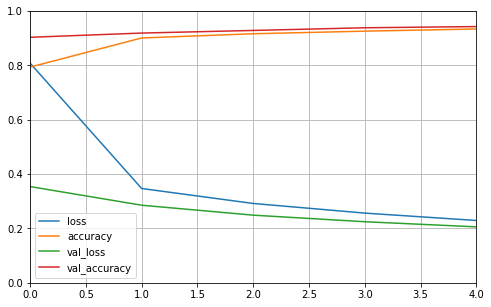

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

plot_learning_curves(history)

In [10]:
# 使用经过 from_tensor_slices 处理的数据训练
model.fit(db_train, validation_data=db_valid, epochs=5)

Epoch 1/5
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.9924 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
782/782 [==============================] - 3s 4ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/5
782/782 [==============================] - 3s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/5
782/782 [==============================] - 3s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/5
782/782 [==============================] - 3s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000


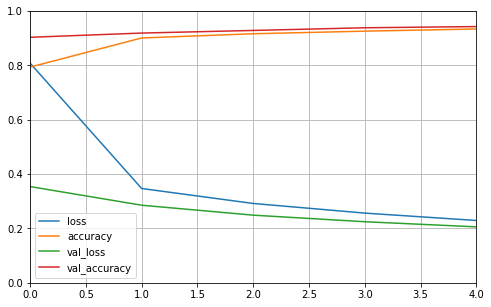

In [11]:
plot_learning_curves(history)

**自定义训练模型**

In [ ]:
# 使用 convert_to_tensor 方法
for step, (x,y) in enumerate(db):

    with tf.GradientTape() as tape:
        # 打平操作，[b, 28, 28] => [b, 784]
        # x = tf.reshape(x, (-1, 28*28))
        # Step1. 得到模型输出output [b, 784] => [b, 10]
        out = model(x)
        # [b] => [b, 10]
        y_onehot = tf.one_hot(y, depth=10)
        # 计算差的平方和，[b, 10]
        loss = tf.square(out-y_onehot)
        # 计算每个样本的平均误差，[b]
        loss = tf.reduce_sum(loss) / x.shape[0]


    acc_meter.update_state(tf.argmax(out, axis=1), y)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


    if step % 2000==0:

        print(step, 'loss:', float(loss), 'acc:', acc_meter.result().numpy())
        acc_meter.reset_states()